In [1]:
import pandas as pd
from pandas.api.types import is_numeric_dtype

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
import keras as keras

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from numpy import array

from statistics import mean as mean
from statistics import stdev as stddev



import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8] # set plot size


2021-12-16 13:25:49.498810: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-16 13:25:49.498835: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from numpy.random import seed
seed (9488)

In [3]:
heart = pd.read_csv ("http://raptor.kent.ac.uk/~ds756/heart.csv")

heart["Bad"] = pd.Series (map (lambda x: "Ill" if x else "Healthy", heart.HeartDisease))

# To keep training time reasonable we'll drop the following features
# Note: We're probably dropping information as well

heart = heart.drop (columns=["Sex", "ChestPainType", "FastingBS", "ExerciseAngina", "ST_Slope", "RestingECG", "HeartDisease"])

heart.columns


Index(['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'Bad'], dtype='object')

<p style="font-size:20px">_____________________________________________________________________________________</p>
<p style="font-size:20px">Build a classifier for the heart dataset.</p>
<p style="font-size:20px">The first step, construct the training data.</p>

(array([ 12.,  37.,  86., 104., 148., 201., 175., 101.,  39.,  15.]),
 array([28. , 32.9, 37.8, 42.7, 47.6, 52.5, 57.4, 62.3, 67.2, 72.1, 77. ]),
 <BarContainer object of 10 artists>)

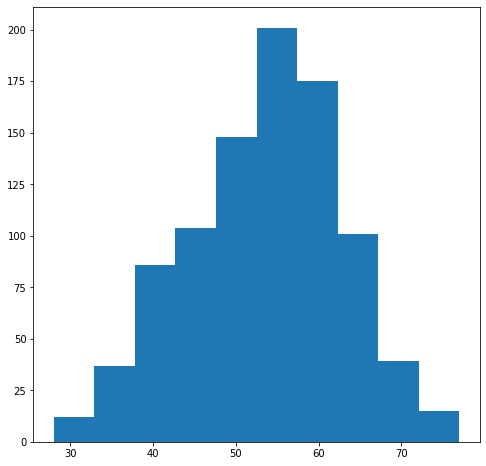

In [4]:
plt.hist (heart.Age)

In [5]:
# Pre-process our continuous features.  We will Z-scoring
#  1. Translate
#  2. Scale

data = heart.copy ()
Answers = heart.Bad
data_len = len (heart)

for u in data:
    if is_numeric_dtype (data[u]):
        data[u] = data[u] - data[u].mean ()             # mean (data[u]) == 0.0
        data[u] = data[u] / stddev (data[u])            # Z-score, scale the distribution

data.describe ()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,9.180000e+02,9.180000e+02,918.000000,9.180000e+02,9.180000e+02
mean,-1.393221e-16,2.089832e-16,0.000000,5.263280e-16,1.083616e-16
std,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
min,-2.704540e+00,-7.151097e+00,-1.817444,-3.016825e+00,-3.269699e+00
25%,-6.902531e-01,-6.695696e-01,-0.233576,-6.602179e-01,-8.319789e-01
50%,5.185271e-02,-1.294423e-01,0.221243,4.676419e-02,-2.694280e-01
75%,6.879435e-01,4.106850e-01,0.623495,7.537463e-01,5.743984e-01
max,2.490201e+00,3.651449e+00,3.695238,2.560478e+00,4.981047e+00


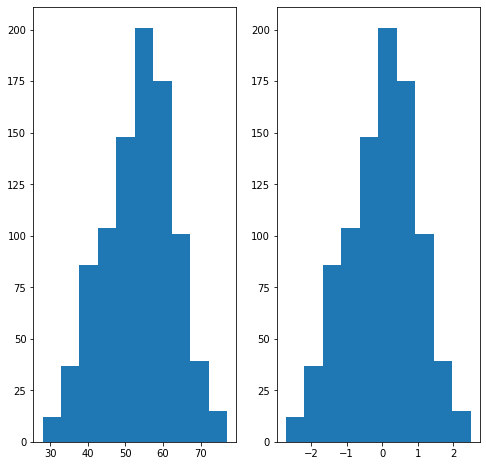

In [6]:
plt.subplot (1, 2, 1)
plt.hist (heart.Age)
plt.subplot (1, 2, 2)
plt.hist (data.Age)
plt.show ()

In [7]:
dataset = data.values               # Extract the values from the dataframe into an array

x = dataset[:, 0:5].astype(float)   # Split off our input features


In [8]:
# Hot-encode our categorical feature (we reshape because we only have 1)

Labels = dataset [:, 5]                    # Split off the outcomes

# Let scikit do the hard work!
PP_Labels = OneHotEncoder ()

# We reshape our labels because each entry needs to be an array, it is a column right now
TrainingLabels = PP_Labels.fit_transform (Labels.reshape (-1, 1)).toarray ()

In [9]:
# Split up our data in to training and verification
# Training 90% of the examples, Test is 10% of the examples
Xtrain, Xtest, Ltrain, Ltest = train_test_split (x, TrainingLabels, test_size = 0.1)

<p style="font-size:20px">_____________________________________________________________________________________</p>
<p style="font-size:20px">We have prepared our data, now build the ANN</p>

In [10]:
model = Sequential()                                                 # Keras container for our model

model.add (Dense (8, input_dim=5, activation='sigmoid'))             # input vector of dim 5
model.add (Dense (8, activation='sigmoid'))                          # Second layer, 8 neurons
model.add (Dense (2, activation='softmax'))                          # Softmax layer

model.compile (loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])    # Build our ANN

model.summary ()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 48        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 2)                 18        
                                                                 
Total params: 138
Trainable params: 138
Non-trainable params: 0
_________________________________________________________________


2021-12-16 13:25:51.082334: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-16 13:25:51.082355: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-16 13:25:51.082368: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter): /proc/driver/nvidia/version does not exist
2021-12-16 13:25:51.082551: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<p style="font-size:20px">_____________________________________________________________________________________</p>
<p style="font-size:20px">We have our training data, and our ANN, we can train the ANN now.</p>

In [11]:
h = model.fit (
    Xtrain, 
    Ltrain, 
    batch_size=500,                   # Randomly select 500 training examples per epoch 
    validation_data = (Xtest, Ltest), # To avoid over-fitting we can monitor the accuracy during training
    verbose=False, 
    epochs = 10000)

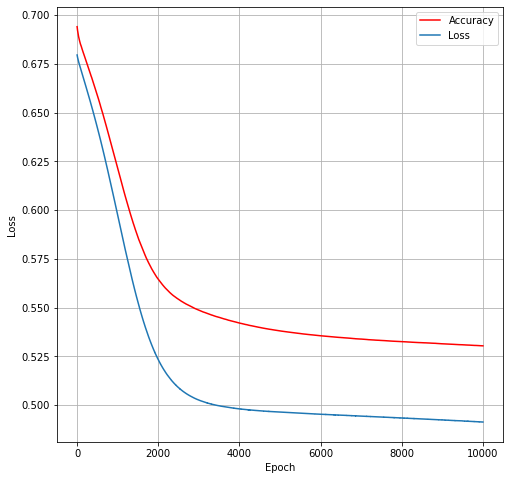

In [12]:
def LossHistory (history):
  plt.plot (history.history['val_loss'], c="r", label='Accuracy')
  plt.plot (history.history['loss'], label='Loss')
  plt.xlabel ('Epoch')
  plt.ylabel ('Loss')
  plt.legend ()
  plt.grid (True)
  plt.show ()

LossHistory (h)

In [13]:
# Extract answer from Softmax

def Inference (x):
    p0 = list (model.predict (query)[0])
    return Answers[p0.index (max (p0))]

In [14]:
wrong = 0

for i in range (0, data_len):
    query = array ([x[i, ]])
    if Inference (query) != Answers[i]:
        wrong = wrong + 1
        # print (i, Inference (query), Answers[i])

print (100 * wrong / data_len, "%")

23.420479302832245 %


<p style="font-size:20px">_____________________________________________________________________________________</p>
<p style="font-size:20px">We can incorporate the normalization in the NN.</p>


In [15]:
dataset = heart.values              # Extract the values from the dataframe into an array
x = dataset[:, 0:5].astype(float)   # Our predictive features

In [16]:
model = Sequential()                                       # Keras container for our model

model.add (keras.layers.Normalization (input_dim = 5))
model.layers[0].adapt (x)

model.compile (loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])    # Build our ANN

y = model.predict (x)
y

array([[-1.4331397 ,  0.41090888,  0.82507   ,  1.3829286 , -0.8324324 ],
       [-0.47848338,  1.4917524 , -0.1719613 ,  0.75415754,  0.10566345],
       [-1.7513584 , -0.12951288,  0.7701876 , -1.5251374 , -0.8324324 ],
       ...,
       [ 0.3701    , -0.12951288, -0.62016803, -0.85706824,  0.29328266],
       [ 0.3701    , -0.12951288,  0.340275  ,  1.461525  , -0.8324324 ],
       [-1.6452855 ,  0.30282453, -0.21769668,  1.4222268 , -0.8324324 ]],
      dtype=float32)

<p style="font-size:20px">_____________________________________________________________________________________</p>
<p style="font-size:20px">Now we can rebuild our ANN with normalization built-in.</p>


In [17]:

model = Sequential()                                       # Keras container for our model

model.add (keras.layers.Normalization (input_dim = 5))
model.layers[0].adapt (x)

model.add (Dense (8, activation='sigmoid'))
model.add (Dense (8, activation='sigmoid'))
model.add (Dense (2, activation='softmax'))

model.compile (loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])    # Build our ANN



In [18]:
Xtrain, Xtest, Ltrain, Ltest = train_test_split (x, TrainingLabels, test_size = 0.1)

In [19]:
h = model.fit (
    Xtrain, 
    Ltrain, 
    batch_size=500, 
    validation_data = (Xtest, Ltest), # To avoid over-fitting we can monitor the accuracy during training
    verbose=False, 
    epochs = 10000)

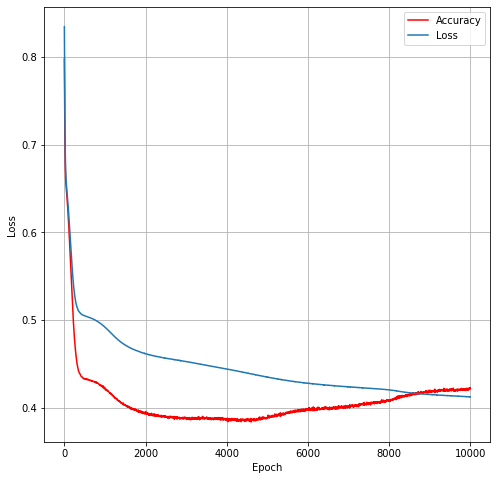

In [20]:
LossHistory (h)

<p style="font-size:20px">_____________________________________________________________________________________</p>
<p style="font-size:20px">Cross-validation is very important.</p>
<p style="font-size:20px">We need to verify that the model works and is not over-fitted.</p>





In [21]:
# This function will create models on demand
#
# Remember - they aren't trained.  Just the raw clay waiting to be moulded.

def MFactory ():
    model = Sequential()

    model.add (keras.layers.Normalization (input_dim = 5))
    model.layers[0].adapt (x)

    model.add (Dense (8, activation='sigmoid'))
    model.add (Dense (8, activation='sigmoid'))
    model.add (Dense (2, activation='softmax'))

    model.compile (loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    return model

In [22]:
kfold = StratifiedKFold (n_splits=3, shuffle=True)
verify = []

print (model.metrics_names) # Cheating, model already exists in our Jupyter kernel

#
# Loop through different (3) combinations of the data
#
for train, test in kfold.split (x, heart.Bad):

    predictor = MFactory ()                      # Fresh ANN

    h = predictor.fit (x[train], TrainingLabels[train], verbose=False, epochs=1000, batch_size = 500)
    Worked = predictor.evaluate (x[test], TrainingLabels[test], verbose=False)

    print (Worked)
    verify.append (100 * Worked[1])




['loss', 'accuracy']
[0.5627294182777405, 0.7352941036224365]
[0.5192891955375671, 0.7450980544090271]
[0.42373228073120117, 0.8300653696060181]
77.01525092124939 5.211710365280203


In [24]:
print (mean (verify), stddev (verify))

77.01525092124939 5.211710365280203
